# ***1. Data Pre-processing***

In [1]:
# Import all required libraries
import pandas as pd
import numpy as np

import tensorflow as tf
from IPython.display import display

from sklearn.preprocessing import MinMaxScaler
from ydata_synthetic.synthesizers.timeseries import TimeSeriesSynthesizer
from ydata_synthetic.synthesizers import ModelParameters, TrainParameters

from table_evaluator import load_data, TableEvaluator
from sklearn.impute import SimpleImputer
import warnings


C:\Users\paulo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\table_evaluator\__init__.py:1: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


IPython not installed.


In [2]:
warnings.filterwarnings('ignore', category=UserWarning)
# ==============================================================================
# SECTION 1: DATA PRE-PROCESSING AND SCALING
# ==============================================================================
# --- Step 1: Data Pre-processing ---

df = pd.read_csv('VirtualPatientModels_dfFinal_qDate.csv')

# Store the original column order and a copy of the q_date column
original_cols_order = df.columns.tolist()
original_q_date_full = pd.to_datetime(df['q_date'].copy())

df['q_date'] = pd.to_datetime(df['q_date'])
df = df.sort_values(by=['part_id', 'q_date'])
df['time_delta_days'] = df.groupby('part_id')['q_date'].diff().dt.days.fillna(0).astype(int)

numerical_cols = ['bmi_score', 'gait_get_up', 'bmi_body_fat', 'raise_chair_time', 'waist', 'time_delta_days']
categorical_cols = ['age', 'hospitalization_three_years', 'stairs_number', 'comorbidities_significant_count',
                    'social_text', 'alcohol_units', 'ortho_hypotension', 'balance_single',
                    'gait_optional_binary', 'depression_total_score', 'social_calls',
                    'comorbidities_most_important', 'iadl_grade', 'house_suitable_professional',
                    'comorbidities_count', 'leisure_out', 'gender', 'house_suitable_participant',
                    'memory_complain', 'living_alone', 'health_rate', 'weight_loss',
                    'low_physical_activity', 'social_phone', 'life_quality',
                    'health_rate_comparison', 'sleep']

# Store original categorical values and perform one-hot encoding with integer values
one_hot_map = {}
for col in categorical_cols:
    df[col] = df[col].astype('category')
    one_hot_map[col] = list(df[col].cat.categories)

df_encoded = pd.get_dummies(df, columns=categorical_cols, prefix=categorical_cols, dtype=np.int8)

# Drop columns that are not features for the model input
df_encoded = df_encoded.drop(columns=['q_date', 'clinical_visit'])

# The list of columns for training must not include `part_id`
columns_for_training = df_encoded.drop(columns='part_id').columns

scaler = MinMaxScaler()
scaler.fit(df_encoded.drop(columns='part_id')[columns_for_training])
df_encoded[columns_for_training] = scaler.transform(df_encoded.drop(columns='part_id')[columns_for_training])


# ***2. Time-GAN Model Setup and Training to generate Synthetic data***

In [ ]:
warnings.filterwarnings('ignore', category=UserWarning)
# ==============================================================================
# SECTION 2: TIME-GAN MODEL SETUP AND TRAINING 
# ==============================================================================

#increase noise_dim  for diversity
#increase layers_dim  for capacity
gan_args = ModelParameters(
    batch_size=128, lr=5e-4, noise_dim=64, layers_dim=256, latent_dim=32, gamma=1 #gamma=1 Used for discriminator loss
)

max_seq_len = max(len(group) for _, group in df.groupby('part_id'))
num_features = len(columns_for_training)

train_args = TrainParameters(
    epochs=2000, sequence_length=max_seq_len, number_sequences=num_features
)

print(f"Max Sequence Length: {max_seq_len}, Total Features: {num_features}")
print(f"Starting TimeGAN Training ({train_args.epochs} epochs)...")

# Initialize the synthesizer
synth = TimeSeriesSynthesizer(
    modelname='timegan', 
    model_parameters=gan_args
)

# use 'train_arguments' 
synth.fit(
    data=df_encoded.drop(columns='part_id'), 
    train_arguments=train_args,
    num_cols=columns_for_training.to_list() 
)

print("TimeGAN Training Complete.")

Max Sequence Length: 4, Total Features: 245
Starting TimeGAN Training (2000 epochs)...
A DataProcessor is not available for the TimeGAN.



Joint networks training: 100%|██████████| 2000/2000 [33:07<00:00,  1.01it/s]

TimeGAN Training Complete.


# ***3. Post-processing and Reverting the Scaling/Encoding to final synthetic dataframe***

In [4]:
# ==============================================================================
# SECTION 3: UNCONDITIONAL GENERATION AND POST-PROCESSING FOR BALANCING
# ==============================================================================

health_rate_categories = one_hot_map['health_rate']
HEALTH_RATE_LABELS = [f'health_rate_{cat}' for cat in health_rate_categories]
NUM_CLASSES = len(HEALTH_RATE_LABELS)

# --- Define Target Parameters for Balancing ---
TARGET_RECORDS_PER_CLASS = 4000
TARGET_SEQUENCES_PER_CLASS = int(np.ceil(TARGET_RECORDS_PER_CLASS / max_seq_len))
TOTAL_REQUIRED_SEQUENCES = TARGET_SEQUENCES_PER_CLASS * NUM_CLASSES

# Generate enough samples plus a buffer for rejection sampling.
# Increased Generation Buffer Factor from 1.5 to 5.0 
GENERATION_BUFFER_FACTOR = 5.0 
UNCONDITIONAL_SAMPLES_TO_GENERATE = int(TOTAL_REQUIRED_SEQUENCES * GENERATION_BUFFER_FACTOR)

print("-" * 80)
print(f"Conditional sampling failed. Generating {UNCONDITIONAL_SAMPLES_TO_GENERATE} UNCONDITIONAL sequences and filtering...")

# TimeGAN.sample() takes only 1 explicit POSITIONAL argument, which must be the sample count.
synth_data_list = synth.sample(
    UNCONDITIONAL_SAMPLES_TO_GENERATE # 1. n_samples (Positional)
)

# Convert the returned list to a NumPy array
synth_data_unconditional = np.array(synth_data_list)
print(f"Unconditional sequences generated: {synth_data_unconditional.shape[0]}")


# --- Filtering and Re-balancing ---

# 1. Flatten the synthetic data for easier class filtering
synth_data_np = synth_data_unconditional 
synth_data_flat = synth_data_np.reshape(-1, num_features)

# 2. Extract the health_rate column indices
health_rate_indices = [columns_for_training.to_list().index(label) for label in HEALTH_RATE_LABELS]
health_rate_columns_data = synth_data_np[:, :, health_rate_indices]

# 3. Determine the class of each sequence based on the majority health_rate value
sequence_classes = []
for seq in health_rate_columns_data:
    # Sum the one-hot values across the sequence length (time steps)
    class_totals = np.sum(seq, axis=0)
    # The class is the one with the highest total value across all time steps
    majority_class_index = np.argmax(class_totals)
    sequence_classes.append(HEALTH_RATE_LABELS[majority_class_index])

# 4. Filter the sequences to meet the target count for each class
final_synth_data_list = []
class_counts = {label: 0 for label in HEALTH_RATE_LABELS}

for seq_index, seq_class in enumerate(sequence_classes):
    if class_counts[seq_class] < TARGET_SEQUENCES_PER_CLASS:
        final_synth_data_list.append(synth_data_np[seq_index])
        class_counts[seq_class] += 1

synth_data = np.array(final_synth_data_list)
print(f"Total sequences selected after filtering: {synth_data.shape[0]}")


# --- Post-processing and Reverting the Scaling/Encoding ---
synth_data_np = np.array(synth_data)
synth_data_flat = synth_data_np.reshape(-1, num_features)

synth_data_rescaled = scaler.inverse_transform(synth_data_flat)
synth_data_rescaled = synth_data_rescaled.reshape(-1, max_seq_len, num_features)

synth_df_list = []
synthetic_part_id_counter = 3000 

unique_start_dates = df.groupby('part_id')['q_date'].min().tolist()

for i in range(synth_data_rescaled.shape[0]):
    temp_df = pd.DataFrame(synth_data_rescaled[i], columns=columns_for_training)
    temp_df_reverted = pd.DataFrame()

    for col_prefix in categorical_cols:
        cols_to_combine = [c for c in temp_df.columns if c.startswith(col_prefix)]
        if cols_to_combine:
            reverted_col_indices = np.argmax(temp_df[cols_to_combine].values, axis=1)
            reverted_col_indices = np.clip(reverted_col_indices, 0, len(one_hot_map[col_prefix]) - 1)
            reverted_col = [one_hot_map[col_prefix][idx] for idx in reverted_col_indices]
            temp_df_reverted[col_prefix] = reverted_col
            
    for col in numerical_cols:
        temp_df_reverted[col] = temp_df[col]
    
    if not unique_start_dates:
        start_date = pd.to_datetime('2016-01-01')
    else:
        start_date = pd.to_datetime(np.random.choice(unique_start_dates))
    
    dates = [start_date]
    for _ in range(1, len(temp_df_reverted)):
        time_delta_days = np.random.randint(182, 274)
        next_date = dates[-1] + pd.Timedelta(days=time_delta_days)
        dates.append(next_date)
    
    temp_df_reverted['q_date'] = dates
    
    temp_df_reverted['clinical_visit'] = range(1, len(temp_df_reverted) + 1)
    temp_df_reverted['part_id'] = synthetic_part_id_counter 
    
    synth_df_list.append(temp_df_reverted)
    synthetic_part_id_counter += 1

final_synthetic_data = pd.concat(synth_df_list, ignore_index=True)
final_synthetic_data = final_synthetic_data.reindex(columns=original_cols_order)

for col in final_synthetic_data.columns:
    if col in categorical_cols:
        if pd.api.types.is_numeric_dtype(df[col]):
            final_synthetic_data[col] = pd.to_numeric(final_synthetic_data[col], errors='coerce').round(0).astype('Int64')
        else:
            final_synthetic_data[col] = final_synthetic_data[col].astype('category')
    elif col in numerical_cols:
        final_synthetic_data[col] = pd.to_numeric(final_synthetic_data[col], errors='coerce')

print("\n" + "="*80)
print("BALANCED SYNTHETIC DATA GENERATION COMPLETE")
print("New Synthetic Health Rate Distribution:")
print(final_synthetic_data['health_rate'].value_counts(normalize=True).mul(100).round(2).astype(str) + '%')
print(final_synthetic_data['health_rate'].value_counts())

--------------------------------------------------------------------------------
Conditional sampling failed. Generating 25000 UNCONDITIONAL sequences and filtering...
Unconditional sequences generated: 25000
Total sequences selected after filtering: 3976

BALANCED SYNTHETIC DATA GENERATION COMPLETE
New Synthetic Health Rate Distribution:
health_rate
5 - Excellent    47.88%
3 - Medium       17.45%
4 - Good         12.27%
1 - Very bad     11.98%
2 - Bad          10.42%
Name: proportion, dtype: object
health_rate
5 - Excellent    7615
3 - Medium       2775
4 - Good         1952
1 - Very bad     1905
2 - Bad          1657
Name: count, dtype: int64


## 3.1 Final dataframe to csv file 

In [5]:
final_synthetic_data.to_csv("VirtualPatientModels_timeGANsynthData_Final_Balanced_Dis.csv", index=False)

# ***4. Evaluation of Samples***

C:\Users\paulo\AppData\Local\Temp\ipykernel_61548\1767917916.py:40: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_eval[col].fillna(mode_value_df, inplace=True)
C:\Users\paulo\AppData\Local\Temp\ipykernel_61548\1767917916.py:43: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For e

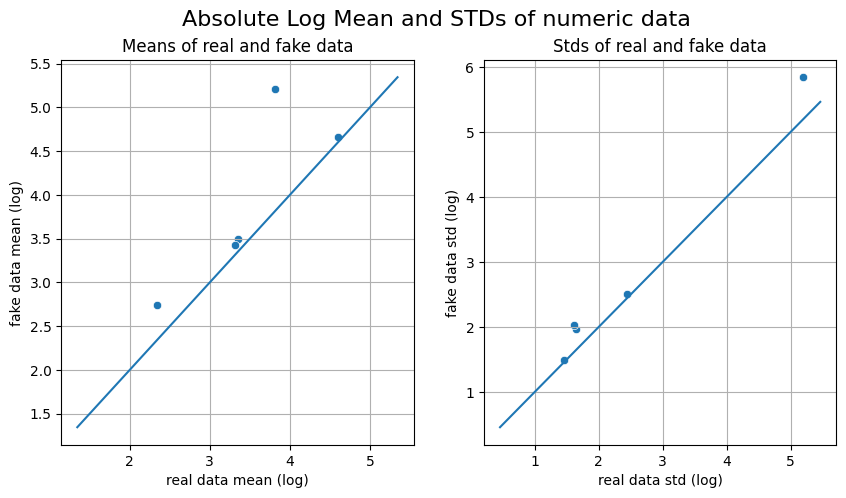

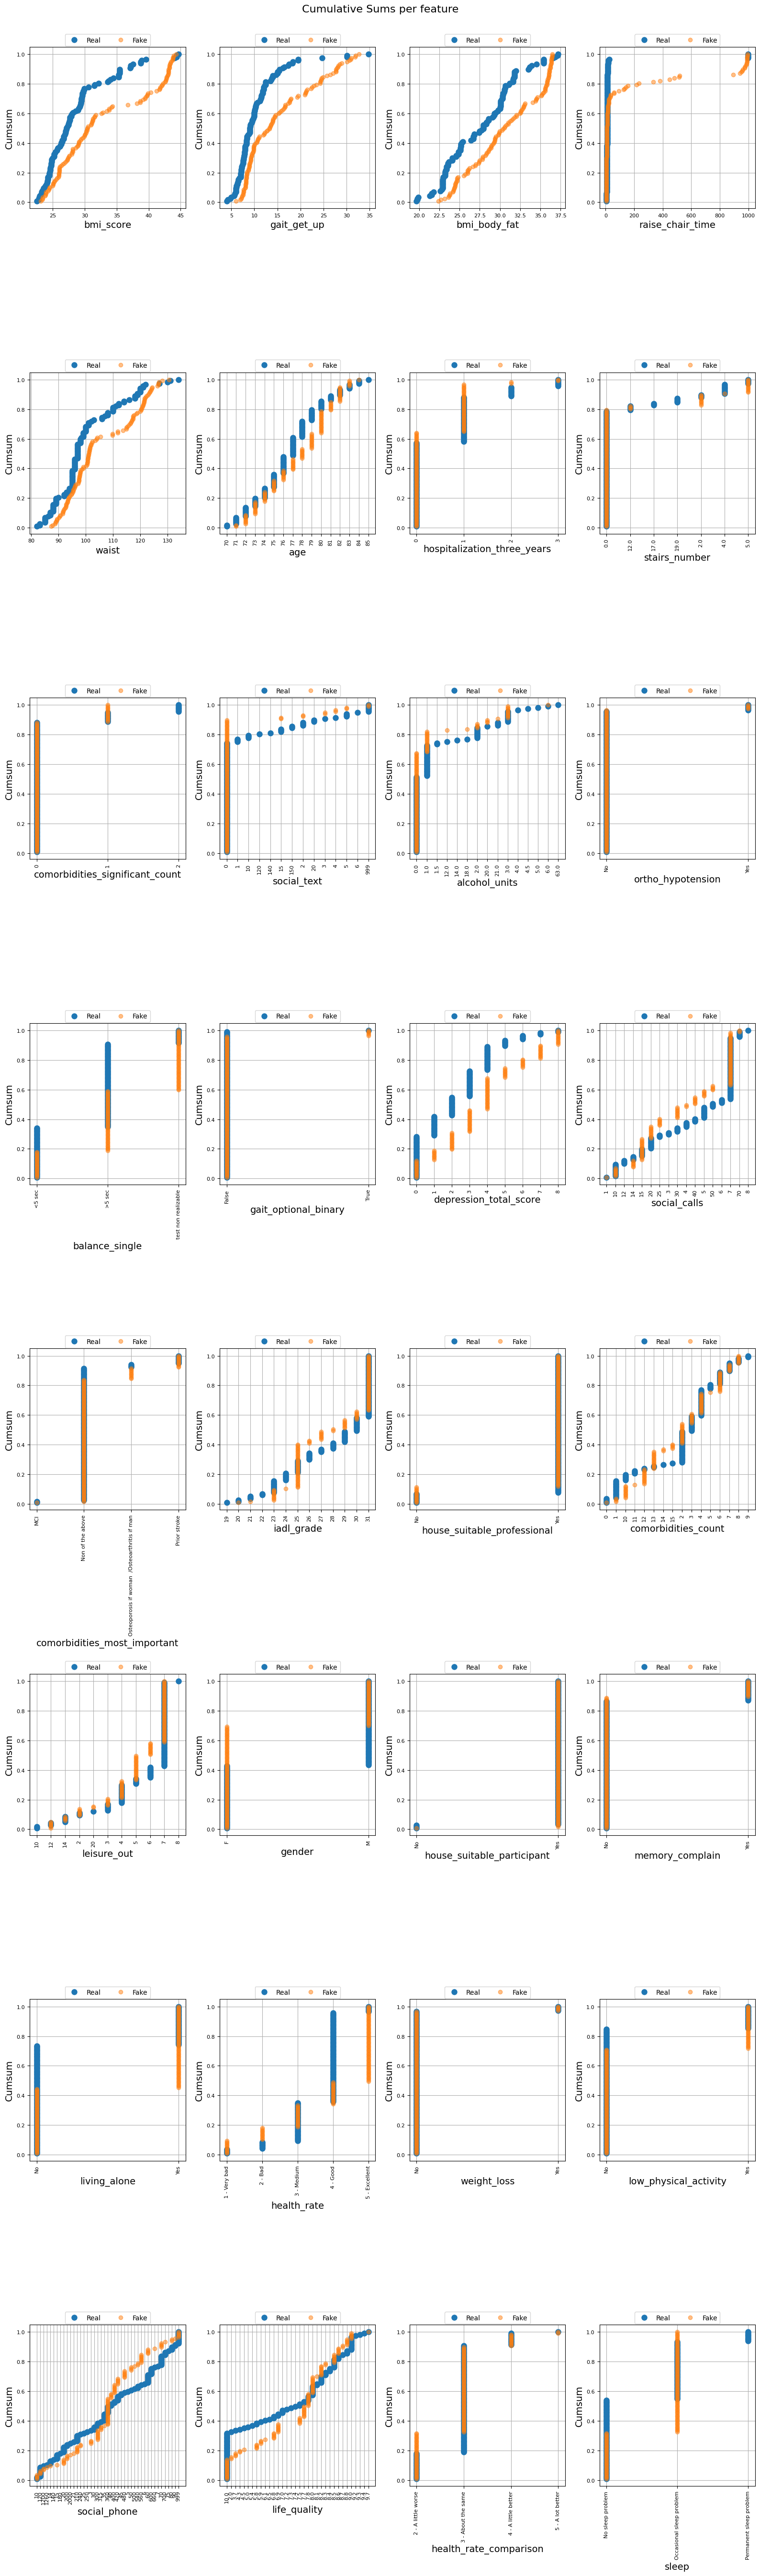

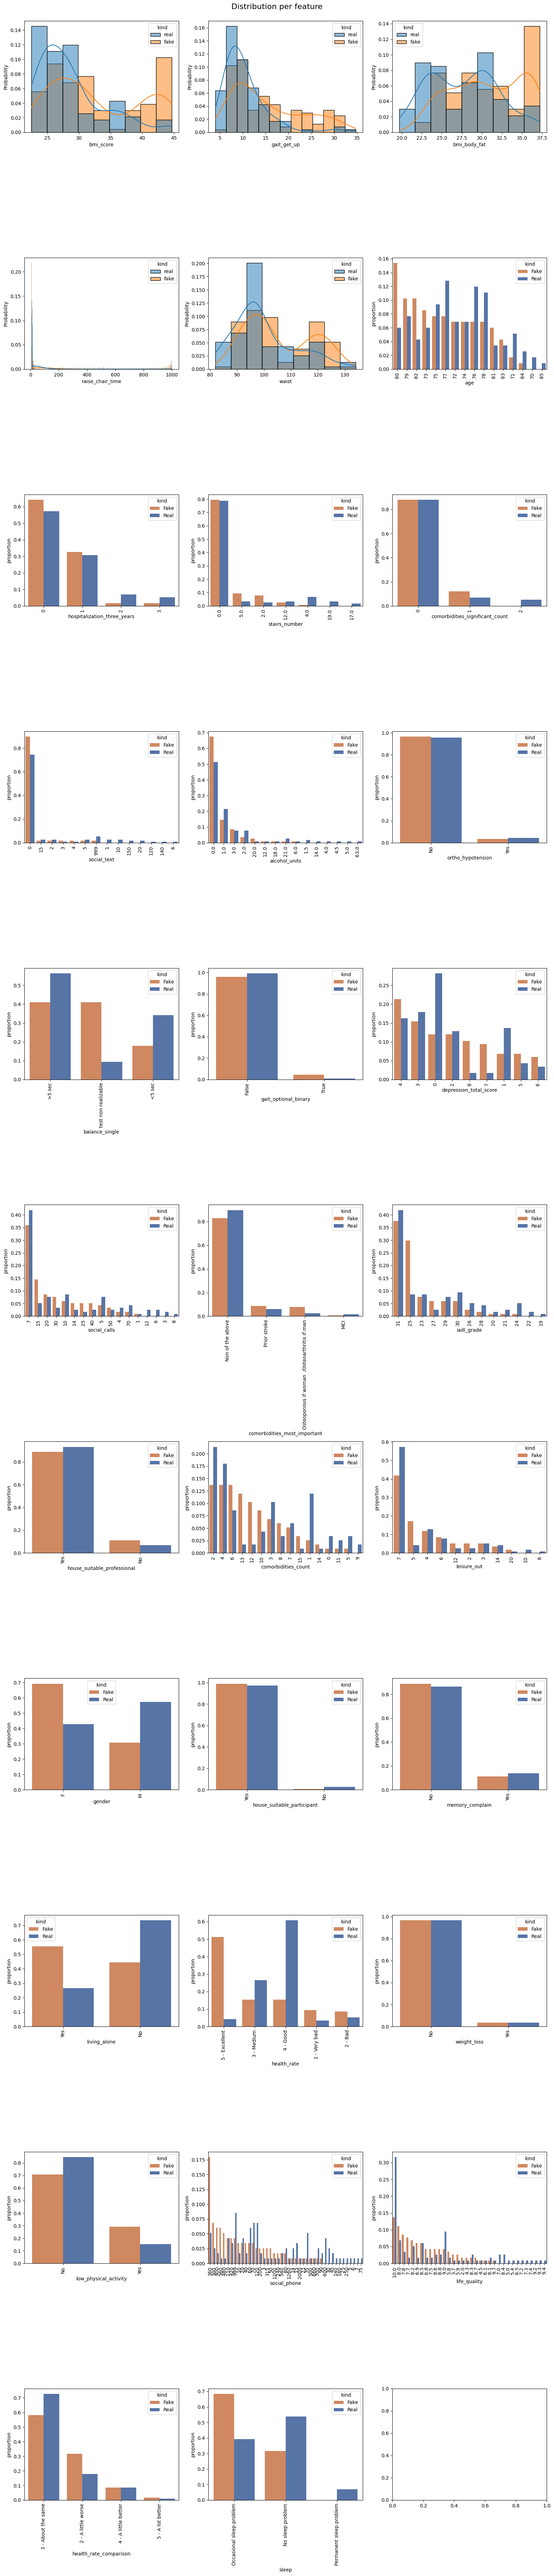

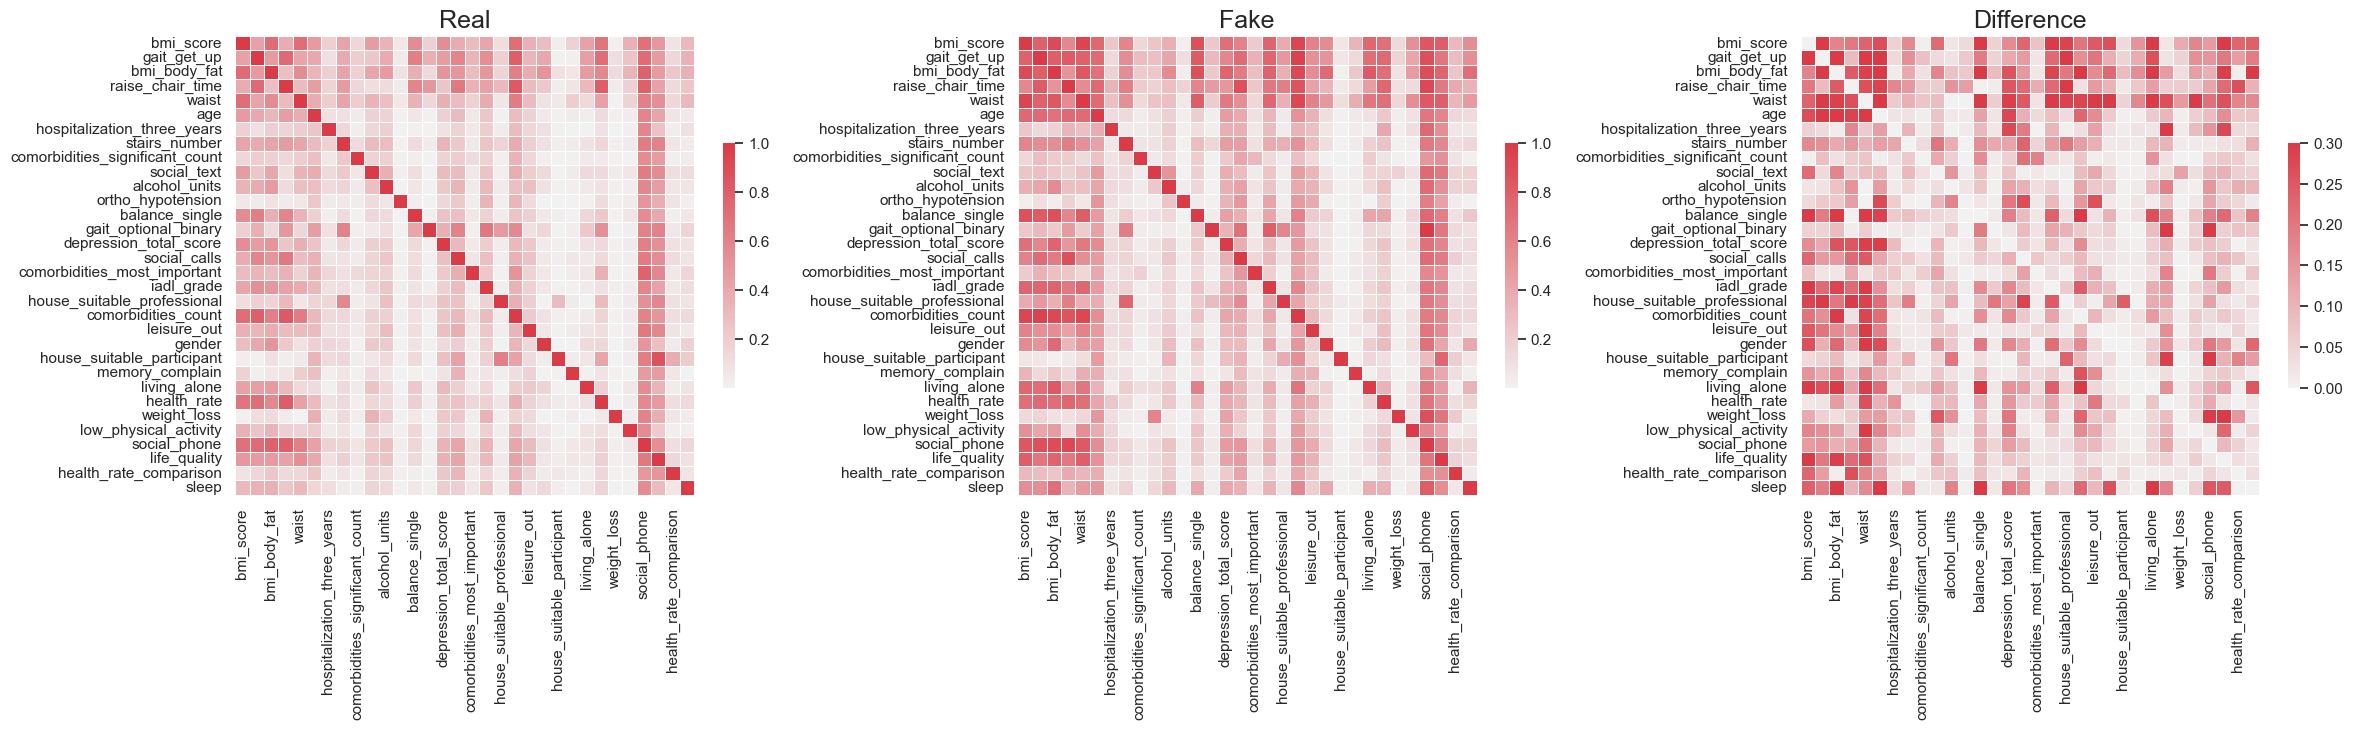

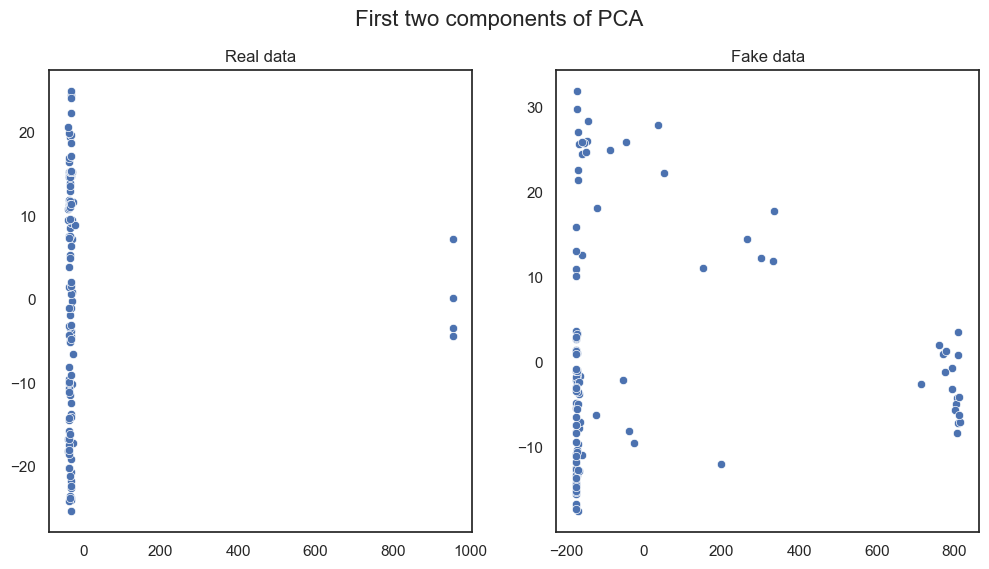

In [6]:
warnings.filterwarnings('ignore', category=UserWarning)

# Create a sample of the original data to match the size of the original data
n_samples = df.shape[0]
sampled_synthetic_data = final_synthetic_data.sample(n=n_samples, random_state=42)

# Create a temporary copy to avoid chained assignment warnings
df_eval = df.copy()
sampled_synthetic_data_eval = sampled_synthetic_data.copy()

# Correct the numerical_cols list to exclude 'time_delta_days' 
numerical_cols = [
    'bmi_score', 'gait_get_up', 'bmi_body_fat', 'raise_chair_time', 'waist'
]
categorical_cols = [
    'age', 'hospitalization_three_years', 'stairs_number', 'comorbidities_significant_count',
    'social_text', 'alcohol_units', 'ortho_hypotension', 'balance_single',
    'gait_optional_binary', 'depression_total_score', 'social_calls',
    'comorbidities_most_important', 'iadl_grade', 'house_suitable_professional',
    'comorbidities_count', 'leisure_out', 'gender', 'house_suitable_participant',
    'memory_complain', 'living_alone', 'health_rate', 'weight_loss',
    'low_physical_activity', 'social_phone', 'life_quality',
    'health_rate_comparison', 'sleep'
]
columns_to_exclude = ['part_id', 'q_date', 'clinical_visit']

# Define the final lists of columns for evaluation
numerical_cols_for_eval = [c for c in numerical_cols if c in df_eval.columns]
categorical_cols_for_eval = [c for c in categorical_cols if c in df_eval.columns]
final_eval_cols = numerical_cols_for_eval + categorical_cols_for_eval

# Impute numerical columns using SimpleImputer
imputer_numerical = SimpleImputer(strategy='mean')
df_eval[numerical_cols_for_eval] = imputer_numerical.fit_transform(df_eval[numerical_cols_for_eval])
sampled_synthetic_data_eval[numerical_cols_for_eval] = imputer_numerical.fit_transform(sampled_synthetic_data_eval[numerical_cols_for_eval])

# Manually impute categorical columns using pandas
for col in categorical_cols_for_eval:
    mode_value_df = df_eval[col].mode()[0]
    df_eval[col].fillna(mode_value_df, inplace=True)
    
    mode_value_synth = sampled_synthetic_data_eval[col].mode()[0]
    sampled_synthetic_data_eval[col].fillna(mode_value_synth, inplace=True)

# use the cleaned data for evaluation.
table_evaluator = TableEvaluator(
    df_eval[final_eval_cols],
    sampled_synthetic_data_eval[final_eval_cols],
    cat_cols=categorical_cols_for_eval
)

table_evaluator.visual_evaluation()

# ***5. Merge real and synthetic data***

In [7]:

# --- 1. Define file paths ---
file1 = 'VirtualPatientModels_dfFinal_qDate.csv'  # Replace with your first file path
file2 = 'VirtualPatientModels_timeGANsynthData_Final_Balanced_Dis.csv'  # Replace with your second file path
output_file = 'VirtualPatientModels_tGANsynthDatacombined_Final_Balanced_Dis.csv' # Output file name

# --- 2. Load DataFrames ---
try:
    df1 = pd.read_csv(file1)
    print(f"'{file1}' loaded successfully.")
    df2 = pd.read_csv(file2)
    print(f"'{file2}' loaded successfully.")
    
    # --- 3. Align Columns and Data Types ---
    if set(df1.columns) != set(df2.columns):
        print("Error: Column names do not match. Cannot proceed with concatenation.")
    else:
        # Reorder df2 to match df1's column order
        df2 = df2[df1.columns]
        print("Columns have been aligned.")
        
        # Unify data types to a common, safe type
        for col in df1.columns:
            if df1[col].dtype != df2[col].dtype:
                print(f"Warning: Dtype mismatch for column '{col}'. Converting to a common type.")
                common_dtype = np.result_type(df1[col].dtype, df2[col].dtype)
                df1[col] = df1[col].astype(common_dtype)
                df2[col] = df2[col].astype(common_dtype)
        
        # --- 4. Concatenate DataFrames ---
        combined_df = pd.concat([df1, df2], ignore_index=True)
        print("\nDataFrames successfully concatenated!")
        print("Combined DataFrame Info:")
        combined_df.info()

        # --- 5. Export to CSV without the index ---
        try:
            combined_df.to_csv(output_file, index=False)
            print(f"\nCombined DataFrame exported to '{output_file}' successfully!")
        except Exception as e:
            print(f"\nError exporting file: {e}")

except FileNotFoundError as e:
    print(f"Error: {e}")

'VirtualPatientModels_dfFinal_qDate.csv' loaded successfully.
'VirtualPatientModels_timeGANsynthData_Final_Balanced_Dis.csv' loaded successfully.
Columns have been aligned.

DataFrames successfully concatenated!
Combined DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16021 entries, 0 to 16020
Data columns (total 35 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   part_id                          16021 non-null  int64  
 1   clinical_visit                   16021 non-null  int64  
 2   bmi_score                        16021 non-null  float64
 3   gait_get_up                      16021 non-null  float64
 4   bmi_body_fat                     16021 non-null  float64
 5   raise_chair_time                 16021 non-null  float64
 6   waist                            16021 non-null  float64
 7   leisure_out                      16021 non-null  int64  
 8   balance_single               